SIR Pyro Object with U value included

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [8]:
class SimpleSEIRModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered model.

    To customize this model we recommend forking and editing this class.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected,
    and "R" for recovered individuals (the recovered individuals are
    implicit: ``R = population - S - E - I``) with transitions
    ``S -> E -> I -> R``.

    :param int population: Total ``population = S + E + I + R``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time, recovery_time, data):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        u = pyro.sample("u", dist.Uniform(0, 0.85))
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        return R0, tau_e, tau_i, rho,u

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, u  = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=(1 - u) * R0 / tau_i,    ## TODO: it seems like in paper, (1-u) * (b1*_i1 + b2*_i2 + b3*_i3)/_n*_s
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau_i))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)



# Assessing the impact of u parameter

In [34]:
population = 10000
recovery_time = 7.
duration = 300
empty_data = [None] * duration
incubation_time = 7.
model = SimpleSEIRModel(population, incubation_time,recovery_time, empty_data)


In [35]:
model.compartments

('S', 'E', 'I')

In [20]:
# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 1.5,"u":.05})
    total_infections = synth_data["S2E"].sum().item()
    print('total_infections:',total_infections)
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


total_infections: 3967.0
total_infections: 9.0
total_infections: 4903.0
Simulated 4903.0 infections after 3 attempts


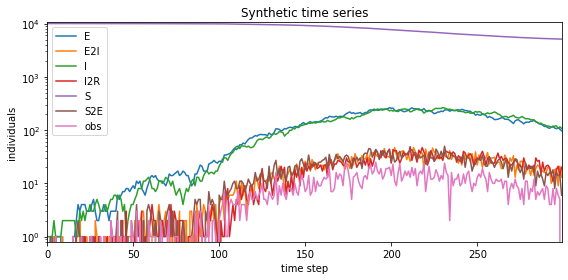

In [21]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

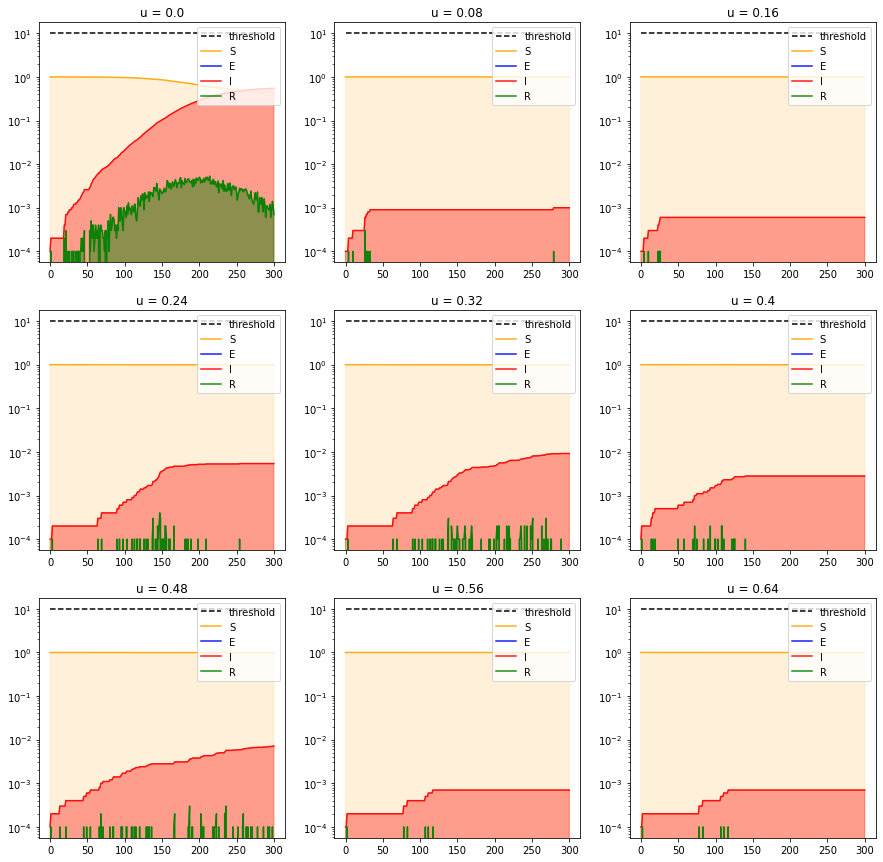

In [36]:
import numpy as np
np.random.seed(1234)
fig, ax = plt.subplots(3,3, figsize=(15,15))
dummyu = np.arange(0, 0.8, 0.08)
count = 0 
for ii in range(3):   # since i is used for the compartmental model
    for j in range(3):
        u = dummyu[count]


        torch.manual_seed(1234)
        pyro.set_rng_seed(1234)
        
        
        data = model.generate({"R0": 1.5,'u':u})
        for attempt in range(100):
            data = model.generate({"R0": 1.5,'u':u})
            total_infections = data["S2E"].sum().item()
           # if 4000 <= total_infections <= 6000:
            break
        #print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

        _S = [population]
        _E = [0]
        _I = [1]
        _R = [0]

        for t in range(duration):
            s = _S[t] - data['S2E'][t]
            e = _E[t] - data['E2I'][t]
            i = _I[t] + data['I2R'][t]
            r = data['I2R'][t]
            _S.append(s)
            _E.append(e)
            _I.append(i)
            _R.append(r)
            
        _S = torch.tensor(_S)/population
        _E = torch.tensor(_E)/population
        _I = torch.tensor(_I)/population
        _R = torch.tensor(_R)/population
        x_vals = np.arange(0, len(_S), 1)  # length of all arrays is the same as duration
        
        ax[ii, j].set_yscale('log')        
        ax[ii, j].plot([population/1000]*len(_S), label='threshold', color='black', linestyle='dashed')
        ax[ii, j].plot(_S, label='S', color='orange', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _S, color='orange', alpha=0.15)
        ax[ii, j].plot(_E, label='E', color='blue', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _E, color='blue', alpha=0.55)
        ax[ii, j].plot(_I, label='I', color='red', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _I, color='red', alpha=0.35)
        ax[ii, j].plot(_R, label='R', color='green', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _R, color='green', alpha=0.45)
        ax[ii, j].legend(loc="upper right")
        ax[ii, j].set_title("u = {}".format(u))
        count += 1

In [33]:
_I

tensor([0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0006, 

In [39]:
data['S2E']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 